# Data EDA

This notebook profiles generated raw, processed, and feature datasets.

In [2]:
from pathlib import Path
import sys
import pandas as pd
import matplotlib.pyplot as plt

root = Path.cwd()
if (root / 'src').exists():
    sys.path.insert(0, str(root / 'src'))
elif (root.parent / 'src').exists():
    sys.path.insert(0, str(root.parent / 'src'))

from altitude_warning.data.pipeline import run_data_pipeline

base = Path('data') if Path('data').exists() else Path('../data')
run_data_pipeline(base_dir=base)
raw_telemetry = pd.read_csv(base / 'raw' / 'telemetry.csv')
raw_weather = pd.read_csv(base / 'raw' / 'weather.csv')
processed = pd.read_csv(base / 'processed' / 'telemetry_processed.csv')
features = pd.read_csv(base / 'processed' / 'ceiling_risk_features.csv')

raw_telemetry.head()

/Users/poojasingh/Documents/2026 AI/2026-FAA/.venv/lib/python3.14/site-packages/langchain_core/_api/deprecation.py:25: UserWarning: Core Pydantic V1 functionality isn't compatible with Python 3.14 or greater.
  from pydantic.v1.fields import FieldInfo as FieldInfoV1


,event_id,drone_id,timestamp_iso,lat,lon,altitude_ft,vertical_speed_fps,ground_speed_fps,heading_deg,gps_fix_ok,signal_strength,message_delay_ms,is_interpolated
0,D-2001-0000,D-2001,2026-02-13T12:00:00Z,37.620000,-122.349800,228.0,1.0,14.000,95.000,0,82,125,1
1,D-2001-0001,D-2001,2026-02-13T12:00:01Z,37.620011,-122.349800,229.0,1.0,14.150,95.125,1,91,35,0
2,D-2001-0002,D-2001,2026-02-13T12:00:02Z,37.620022,-122.349801,230.0,1.0,14.299,95.250,1,91,35,0
3,D-2001-0003,D-2001,2026-02-13T12:00:03Z,37.620033,-122.349803,231.0,1.0,14.445,95.374,1,91,35,0
4,D-2001-0004,D-2001,2026-02-13T12:00:04Z,37.620044,-122.349805,232.0,1.0,14.589,95.497,1,91,36,0


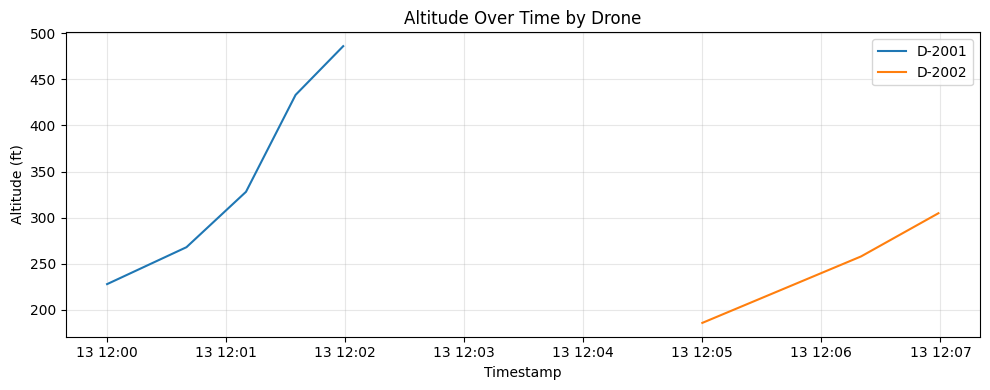

In [18]:
alt_df = raw_telemetry.copy()
alt_df['timestamp_iso'] = pd.to_datetime(alt_df['timestamp_iso'])
drone_palette = {'D-2001': '#1f77b4', 'D-2002': '#ff7f0e'}

fig, ax = plt.subplots(figsize=(10, 4))
for drone_id, part in alt_df.groupby('drone_id'):
    ax.plot(
        part['timestamp_iso'],
        part['altitude_ft'],
        label=drone_id,
        color=drone_palette.get(drone_id),
    )
ax.set_title('Altitude Over Time by Drone')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Altitude (ft)')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()

In [3]:
summary = {
    'raw_telemetry_rows': len(raw_telemetry),
    'raw_weather_rows': len(raw_weather),
    'processed_rows': len(processed),
    'feature_rows': len(features),
    'drones': raw_telemetry['drone_id'].nunique(),
}
pd.Series(summary)

raw_telemetry_rows    240
raw_weather_rows      240
processed_rows        240
feature_rows          240
drones                  2
dtype: int64

In [4]:
grouped = features.groupby('drone_id', as_index=False).agg(
    avg_risk=('risk_score', 'mean'),
    p95_risk=('risk_score', lambda s: s.quantile(0.95)),
    alert_share=('ceiling_cross_within_8s', 'mean')
)
grouped

,drone_id,avg_risk,p95_risk,alert_share
0,D-2001,0.767012,0.995800,0.591667
1,D-2002,0.209540,0.358255,0.000000


In [17]:
from IPython.display import display

fast_df = features.copy()
fast_df['timestamp_iso'] = pd.to_datetime(fast_df['timestamp_iso'])
fast_df['within_8s_cross'] = fast_df['ceiling_cross_within_8s'].astype(int)

summary_counts = fast_df.groupby('drone_id')['within_8s_cross'].agg(['sum', 'count'])
summary_counts = summary_counts.rename(columns={'sum': 'within_8s', 'count': 'total_points'})
summary_counts['not_within_8s'] = summary_counts['total_points'] - summary_counts['within_8s']
display(summary_counts)

cols = [
    'timestamp_iso',
    'drone_id',
    'altitude_ft',
    'vertical_speed_fps',
    'predicted_altitude_ft_8s',
    'ceiling_ft',
    'within_8s_cross',
 ]
display(fast_df.loc[fast_df['within_8s_cross'] == 1, cols].head(12))
display(fast_df.loc[fast_df['within_8s_cross'] == 0, cols].head(12))

,within_8s,total_points,not_within_8s
drone_id,,,
D-2001,71,120,49
D-2002,0,120,120


,timestamp_iso,drone_id,altitude_ft,vertical_speed_fps,predicted_altitude_ft_8s,ceiling_ft,within_8s_cross
49,2026-02-13 12:00:49+00:00,D-2001,286.0,2.0,302.0,300.0,1
50,2026-02-13 12:00:50+00:00,D-2001,288.0,2.0,304.0,300.0,1
51,2026-02-13 12:00:51+00:00,D-2001,290.0,2.0,306.0,300.0,1
52,2026-02-13 12:00:52+00:00,D-2001,292.0,2.0,308.0,300.0,1
53,2026-02-13 12:00:53+00:00,D-2001,294.0,2.0,310.0,300.0,1
54,2026-02-13 12:00:54+00:00,D-2001,296.0,2.0,312.0,300.0,1
55,2026-02-13 12:00:55+00:00,D-2001,298.0,2.0,314.0,300.0,1
56,2026-02-13 12:00:56+00:00,D-2001,300.0,2.0,316.0,300.0,1
57,2026-02-13 12:00:57+00:00,D-2001,302.0,2.0,318.0,300.0,1
58,2026-02-13 12:00:58+00:00,D-2001,304.0,2.0,320.0,300.0,1


,timestamp_iso,drone_id,altitude_ft,vertical_speed_fps,predicted_altitude_ft_8s,ceiling_ft,within_8s_cross
0,2026-02-13 12:00:00+00:00,D-2001,228.0,1.0,236.0,300.0,0
1,2026-02-13 12:00:01+00:00,D-2001,229.0,1.0,237.0,300.0,0
2,2026-02-13 12:00:02+00:00,D-2001,230.0,1.0,238.0,300.0,0
3,2026-02-13 12:00:03+00:00,D-2001,231.0,1.0,239.0,300.0,0
4,2026-02-13 12:00:04+00:00,D-2001,232.0,1.0,240.0,300.0,0
5,2026-02-13 12:00:05+00:00,D-2001,233.0,1.0,241.0,300.0,0
6,2026-02-13 12:00:06+00:00,D-2001,234.0,1.0,242.0,300.0,0
7,2026-02-13 12:00:07+00:00,D-2001,235.0,1.0,243.0,300.0,0
8,2026-02-13 12:00:08+00:00,D-2001,236.0,1.0,244.0,300.0,0
9,2026-02-13 12:00:09+00:00,D-2001,237.0,1.0,245.0,300.0,0


### What this table means
- `D-2001` is the riskier drone in this scenario: higher average risk, higher peak risk, and higher alert share.
- `D-2002` stays mostly in safer operating space in this run.
- Simple takeaway: this setup is intentionally built to show two different risk behaviors clearly.

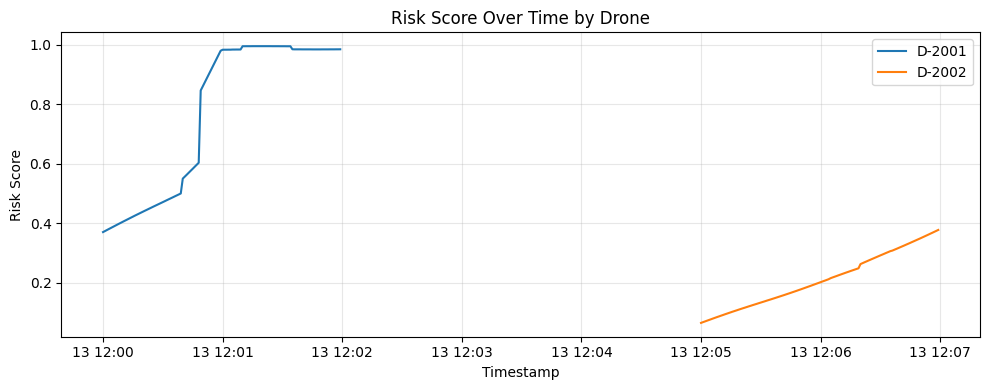

In [5]:
plot_df = features.copy()
plot_df['timestamp_iso'] = pd.to_datetime(plot_df['timestamp_iso'])
drone_palette = {'D-2001': '#1f77b4', 'D-2002': '#ff7f0e'}

fig, ax = plt.subplots(figsize=(10, 4))
for drone_id, part in plot_df.groupby('drone_id'):
    ax.plot(
        part['timestamp_iso'],
        part['risk_score'],
        label=drone_id,
        color=drone_palette.get(drone_id),
    )
ax.set_title('Risk Score Over Time by Drone')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Risk Score')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()

### What this plot means
- The blue and orange lines are not behaving the same: one drone stays much riskier over time.
- In this dataset, that is expected because one drone climbs more aggressively and also has a lower allowed ceiling.
- Simple takeaway: risk is not just about speed; local airspace limits matter too.

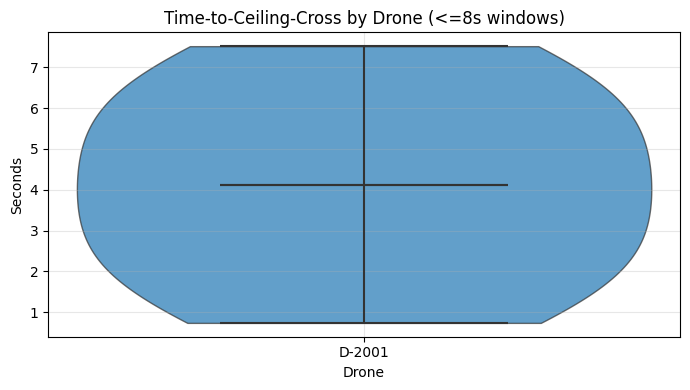

In [13]:
ttc_df = features.copy()
ttc_df['time_to_ceiling_cross_sec'] = pd.to_numeric(
    ttc_df['time_to_ceiling_cross_sec'], errors='coerce'
 )
ttc_df = ttc_df.dropna(subset=['time_to_ceiling_cross_sec'])

ttc_by_drone = [
    ttc_df.loc[ttc_df['drone_id'] == drone, 'time_to_ceiling_cross_sec'].values
    for drone in sorted(ttc_df['drone_id'].unique())
 ]
labels = sorted(ttc_df['drone_id'].unique())
colors = [drone_palette.get(drone, '#999999') for drone in labels]

fig, ax = plt.subplots(figsize=(7, 4))
violin = ax.violinplot(ttc_by_drone, showmeans=True, showmedians=True)
for body, color in zip(violin['bodies'], colors):
    body.set_facecolor(color)
    body.set_edgecolor('#333333')
    body.set_alpha(0.7)
for part in ('cbars', 'cmins', 'cmaxes', 'cmeans', 'cmedians'):
    if part in violin:
        violin[part].set_color('#333333')
ax.set_title('Time-to-Ceiling-Cross by Drone (<=8s windows)')
ax.set_xlabel('Drone')
ax.set_ylabel('Seconds')
ax.set_xticks(range(1, len(labels) + 1), labels)
ax.grid(alpha=0.3)
plt.tight_layout()

In [14]:
d2001_crossings = (
    features.loc[
        features['drone_id'] == 'D-2001',
        'time_to_ceiling_cross_sec',
    ]
    .replace('', pd.NA)
    .dropna()
    .astype(float)
    .sort_values()
    .to_list()
 )
d2001_crossings

[0.737, 1.479, 2.225, 2.975, 3.728, 4.484, 5.242, 6.001, 6.761, 7.52]

### What this chart means
- This chart shows how much warning time is left before a possible ceiling crossing.
- Smaller numbers mean less reaction time.
- Easy rule of thumb for operations:
- `critical`: less than 2 seconds left (act immediately)
- `warning`: 2 to 5 seconds left (prepare and respond)
- `advisory`: more than 5 seconds left (monitor closely)
- This is a small synthetic run, so treat it as a walkthrough example, not a final production threshold policy.

## Feature Inputs for Altitude Warning

This section isolates the primary model inputs so readers can quickly understand which features drive near-term ceiling-risk indicators.

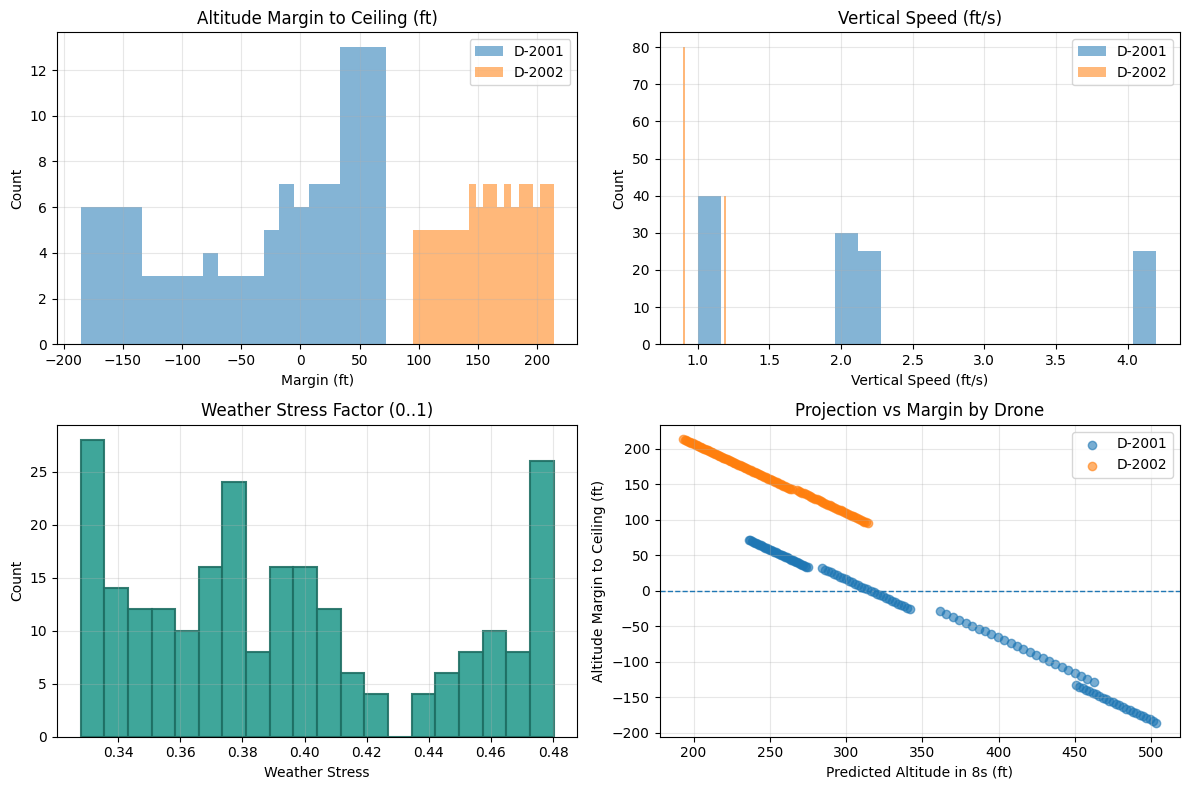

In [11]:
feature_cols = [
    'drone_id',
    'altitude_margin_to_ceiling_ft',
    'vertical_speed_fps',
    'weather_stress_factor',
    'predicted_altitude_ft_8s',
    'ceiling_cross_within_8s'
 ]
plot_features = features[feature_cols].copy()
drone_palette = {'D-2001': '#1f77b4', 'D-2002': '#ff7f0e'}

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for drone_id, part in plot_features.groupby('drone_id'):
    axes[0, 0].hist(part['altitude_margin_to_ceiling_ft'], bins=20, alpha=0.55,
                   label=drone_id, color=drone_palette.get(drone_id))
axes[0, 0].set_title('Altitude Margin to Ceiling (ft)')
axes[0, 0].set_xlabel('Margin (ft)')
axes[0, 0].set_ylabel('Count')
axes[0, 0].legend()

for drone_id, part in plot_features.groupby('drone_id'):
    axes[0, 1].hist(part['vertical_speed_fps'], bins=20, alpha=0.55,
                   label=drone_id, color=drone_palette.get(drone_id))
axes[0, 1].set_title('Vertical Speed (ft/s)')
axes[0, 1].set_xlabel('Vertical Speed (ft/s)')
axes[0, 1].set_ylabel('Count')
axes[0, 1].legend()

axes[1, 0].hist(
    plot_features['weather_stress_factor'],
    bins=20,
    alpha=0.9,
    color='#2a9d8f',
    edgecolor='#1f6f64',
    linewidth=1.5,
 )
axes[1, 0].set_title('Weather Stress Factor (0..1)')
axes[1, 0].set_xlabel('Weather Stress')
axes[1, 0].set_ylabel('Count')

for drone_id, part in plot_features.groupby('drone_id'):
    axes[1, 1].scatter(part['predicted_altitude_ft_8s'], part['altitude_margin_to_ceiling_ft'],
                       alpha=0.6, label=drone_id, color=drone_palette.get(drone_id))
axes[1, 1].axhline(0, linestyle='--', linewidth=1)
axes[1, 1].set_title('Projection vs Margin by Drone')
axes[1, 1].set_xlabel('Predicted Altitude in 8s (ft)')
axes[1, 1].set_ylabel('Altitude Margin to Ceiling (ft)')
axes[1, 1].legend()

for ax in axes.flat:
    ax.grid(alpha=0.3)

plt.tight_layout()


### What these feature plots mean
- Colors separate the two drones so it is easier to see who contributes to risky regions.
- Negative altitude margin means the drone is at or beyond its ceiling buffer.
- Higher vertical speed usually pushes risk up faster.
- Weather stress in this run acts like a multiplier: it increases pressure, but it is not the only cause of risk.
- Projection vs margin gives a quick picture of "how close" and "how soon" at the same time.